In [1]:
#|echo: false

##---- Load all necessary libraries ----##

# math, df, os, misc.
import numpy as np
import pandas as pd
import math
import scipy.io
import os
import random

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# %config InlineBackend.figure_format = 'svg'

# algorithms
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso, Ridge

# (uncomment the commands below when printing notebook to pdf)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300

# 1 - Comparing multi-class classifiers for handwritten digits classification

This question is to compare different classifiers and their performance for multi-class classifications on the complete MNIST dataset at http://yann.lecun.com/exdb/mnist/. You can find the data file `mnist_10digits.mat` in the data folder. The MNIST database of handwritten digits has a training set of 60,000 examples and a test set of 10,000 examples. We will compare **KNN, logistic regression, Linear SVM, kernel SVM, and neural networks**.


- I will "standardize" the features before training the classifiers by dividing the values of the features by 255 (thus mapping the range of the features from [0, 255] to [0, 1]).
- The number of neighbors $K$ used in KNN can be adjusted to have a reasonable result (by using cross-validation but it may not be required; any reasonable tuning to get a good result is acceptable). Only the best k will get reported.
- I will use a neural networks function `sklearn.neural_network` with `hidden_layer_sizes = (20, 10)`. 
- For kernel SVM, I will use radial basis function kernel and choose the proper kernel.
- For KNN and SVM, I can randomly downsample the training data to size $m=5000$, to improve the computation efficiency. 
- Packages may be used for all models in this problem.

I will train the classifiers on the training dataset and evaluate them on the test dataset.

## 1.1 

I can report the confusion matrix, precision, recall, and F-1 score for each of the classifiers. For the precision, recall, and F-1 score of each classifier, we will need to report these for each of the digits which I can do by creating a table. For this question, each of the 5 classifiers, **KNN, logistic regression, Linear SVM, kernel SVM, and neural networks**, accounts for 3 points.
	


In [2]:
#|echo: false

#load data
mat = scipy.io.loadmat("data/mnist_10digits.mat")

X_train = mat["xtrain"]
y_train = mat["ytrain"].flatten() # (1,60000) -> (60000,)

X_test = mat['xtest']
y_test = mat['ytest'].flatten()

# standardize
X_train = X_train/255
X_test = X_test/255

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

seed = 123456 
random.seed(seed)
idx = random.sample(range(len(X_train)), 5000)

X_train_downsampled = X_train[idx]
y_train_downsampled = y_train[idx].flatten()

In [3]:
#|echo: false

classification_models = {'KNN (5 clusters)': KNeighborsClassifier(5),
                         'Logistic Regression': LogisticRegression(solver = 'newton-cg', max_iter = 200),
                         'Linear SVM': SVC(kernel = "linear"),
                         'Kernel SVM': SVC(kernel = 'rbf'),
                         'Neural Net': MLPClassifier(alpha = 1, hidden_layer_sizes = (20, 10))
                         }

def run_classifiers(classification_model):
    model_name = classification_model
    model = classification_models[classification_model]

    downsample_models = ['KNN (5 clusters)', 'Linear SVM', 'Kernel SVM']

    # fit model
    if model_name in downsample_models:
        model.fit(X_train_downsampled, y_train_downsampled)
        # print("Using downsampled data")
    else:
        model.fit(X_train, y_train)
        # print("Using all data")

    # predictions
    y_pred_test = model.predict(X_test) 

    # metrics
    training_acc = model.score(X_train, y_train)
    testing_acc = model.score(X_test, y_test)

    report = classification_report(y_test, y_pred_test, output_dict = True)
    df_report = pd.DataFrame(report).transpose().drop(columns = ['support'])

    display(df_report.style.set_caption(f"Classification Model Report - {model_name}").format(precision = 4))
    plot_confusion_matrix(y_test, y_pred_test, model_name)

    overall_acc = pd.DataFrame({'Model': [classification_model], 
                                'Training Accuracy': [training_acc], 
                                'Testing Accuracy': [testing_acc]})
    
    return overall_acc, df_report

def plot_confusion_matrix(true_labels, pred_labels, title):
    plt.figure(figsize = (5,4))
    cf_matrix = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cf_matrix, 
                annot = True, 
                fmt = '', 
                cmap = 'Greens')
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()

,precision,recall,f1-score
0,0.9390,0.9898,0.9637
1,0.8739,0.9956,0.9308
2,0.9786,0.8857,0.9298
3,0.9194,0.9485,0.9337
4,0.9409,0.9084,0.9244
5,0.9424,0.9170,0.9295
6,0.9498,0.9687,0.9592
7,0.9273,0.9183,0.9228
8,0.9694,0.8460,0.9035
9,0.8939,0.9187,0.9062


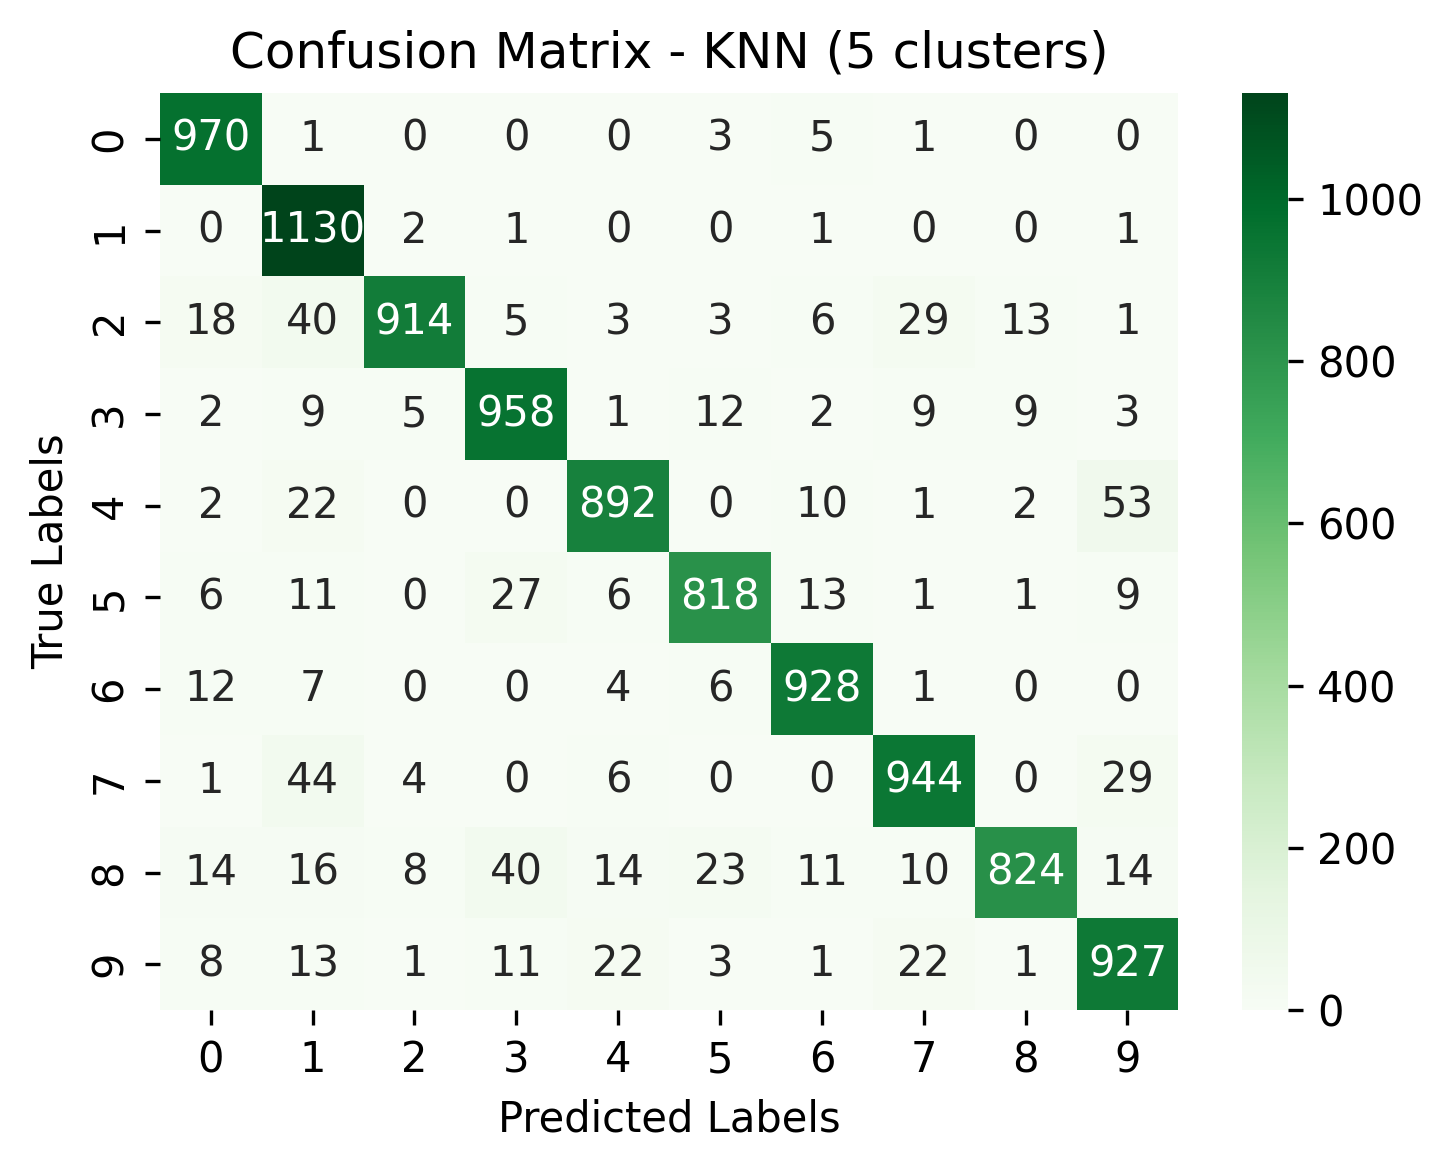

,precision,recall,f1-score
0,0.9532,0.9765,0.9647
1,0.9610,0.9780,0.9694
2,0.9291,0.9021,0.9154
3,0.9031,0.9139,0.9085
4,0.9380,0.9399,0.9390
5,0.8972,0.8711,0.8840
6,0.9422,0.9530,0.9476
7,0.9312,0.9222,0.9267
8,0.8841,0.8768,0.8804
9,0.9112,0.9158,0.9135


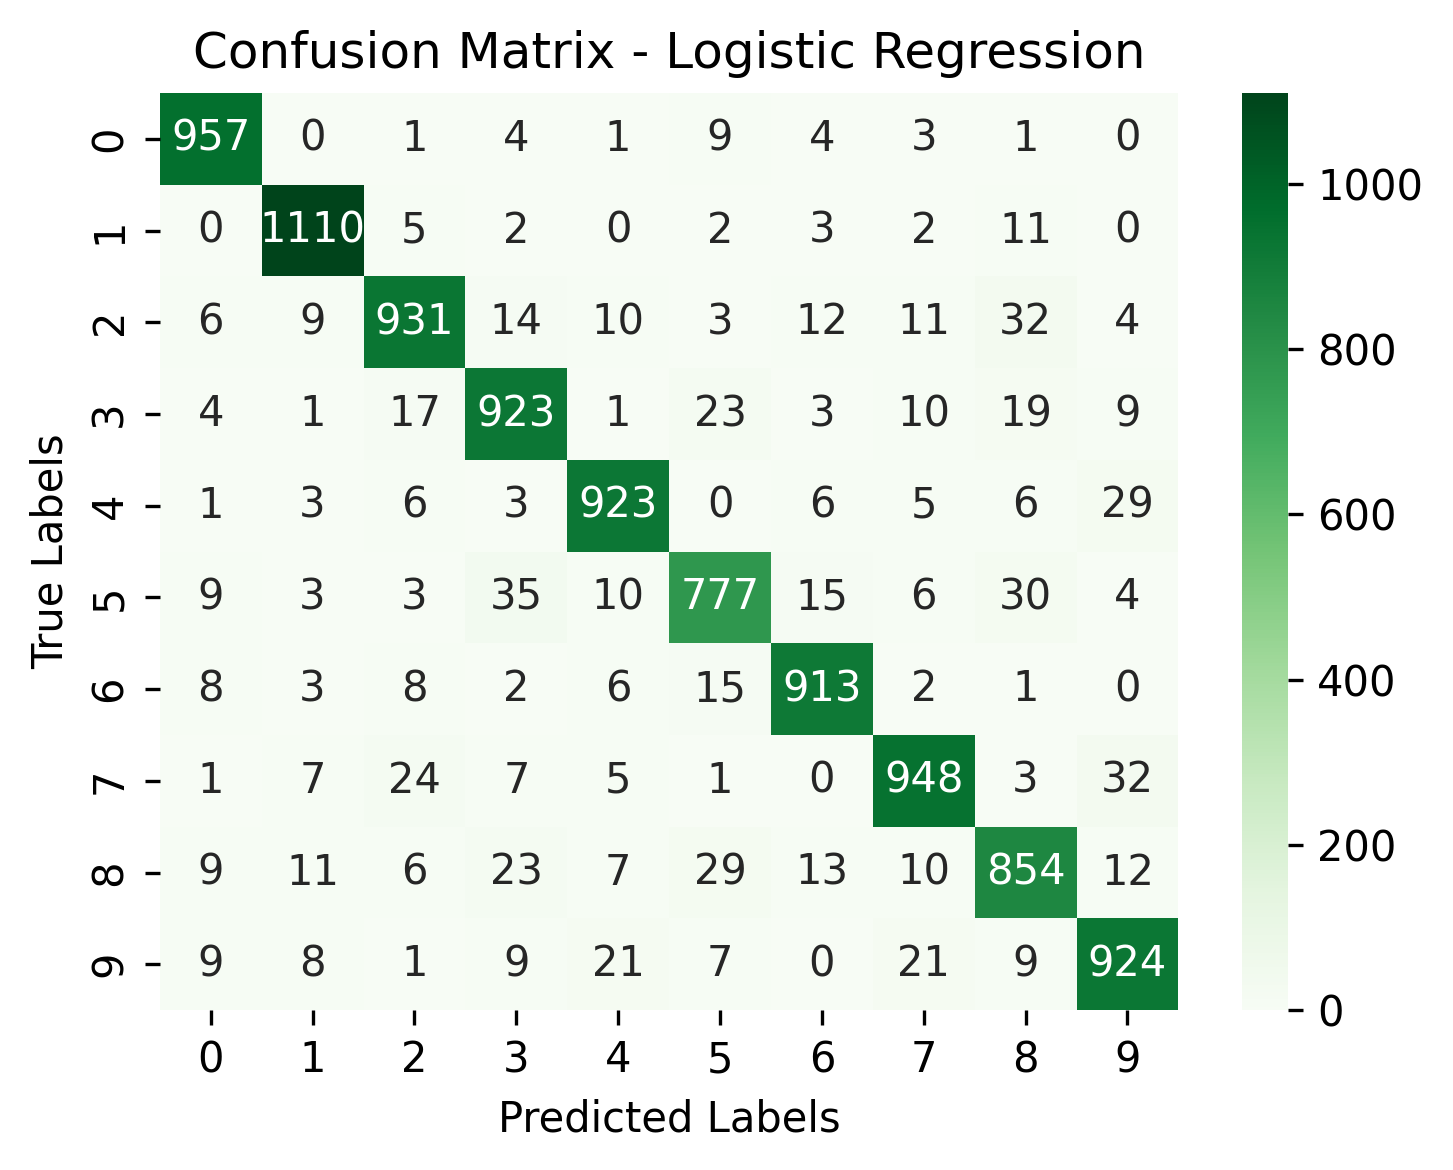

,precision,recall,f1-score
0,0.9223,0.9816,0.9511
1,0.9326,0.9868,0.9589
2,0.8943,0.8934,0.8938
3,0.8926,0.8970,0.8948
4,0.9010,0.9358,0.9181
5,0.8999,0.8565,0.8777
6,0.9479,0.9311,0.9394
7,0.9260,0.9008,0.9132
8,0.9056,0.8573,0.8808
9,0.9008,0.8731,0.8868


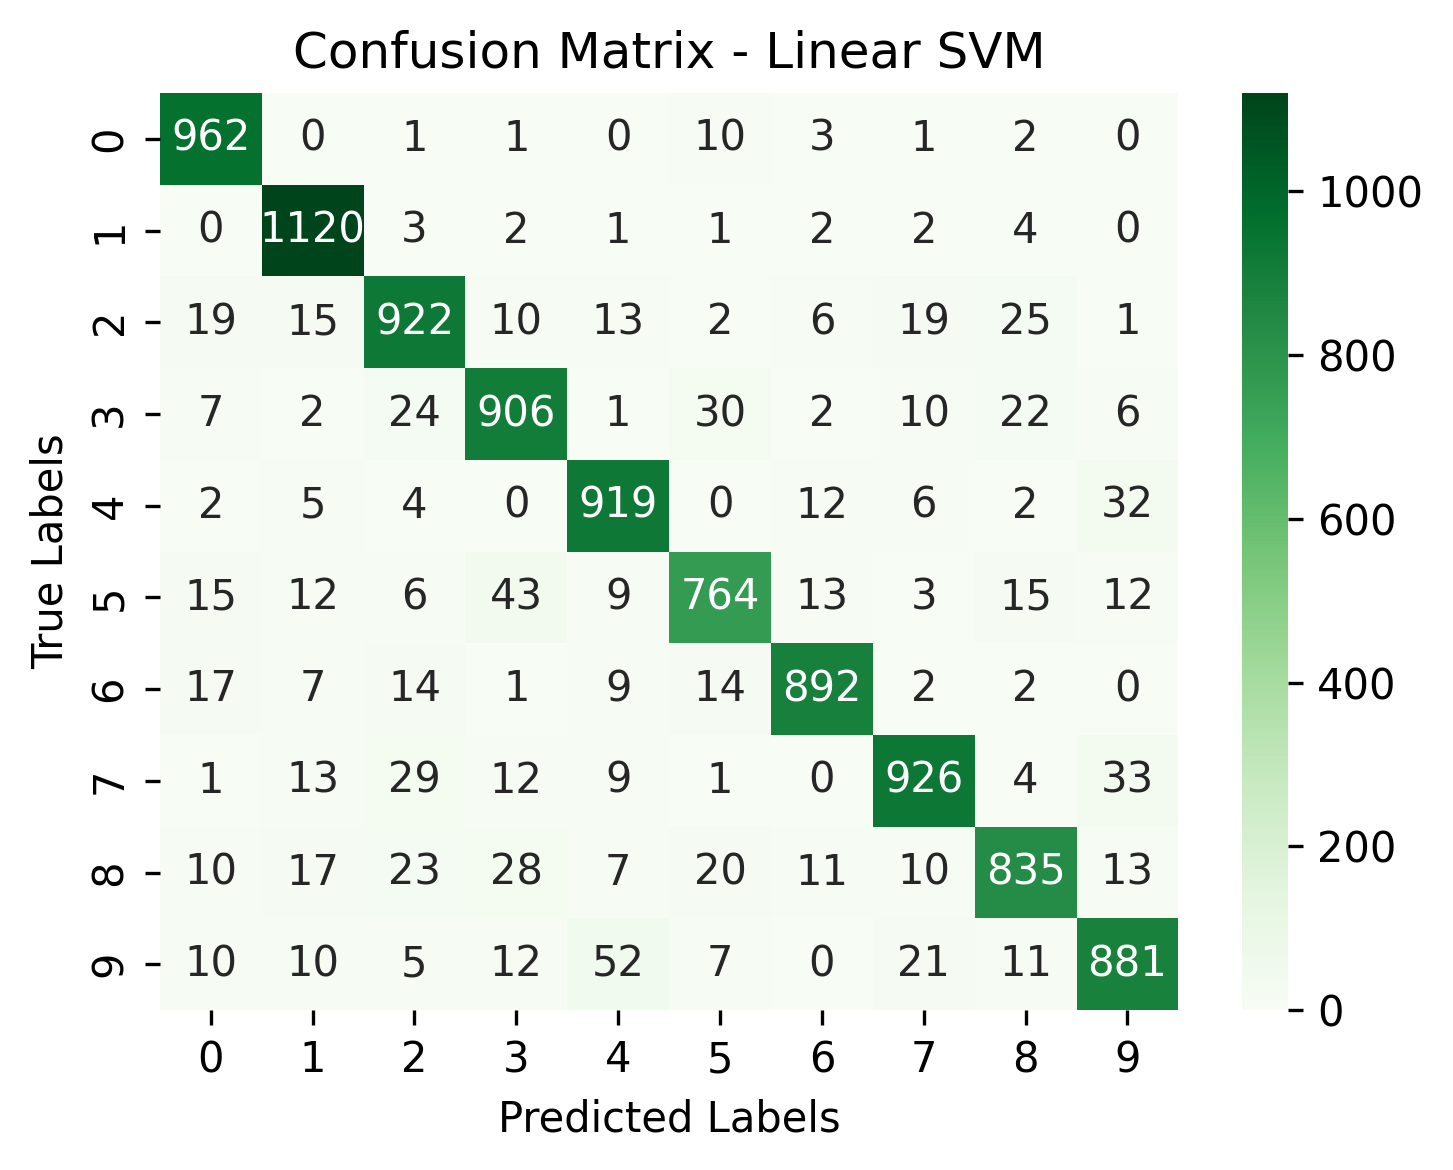

,precision,recall,f1-score
0,0.9661,0.9878,0.9768
1,0.9782,0.9894,0.9838
2,0.9526,0.9351,0.9438
3,0.9518,0.9584,0.9551
4,0.9370,0.9542,0.9455
5,0.9581,0.9484,0.9532
6,0.9489,0.9697,0.9592
7,0.9581,0.9348,0.9463
8,0.9435,0.9251,0.9342
9,0.9350,0.9267,0.9308


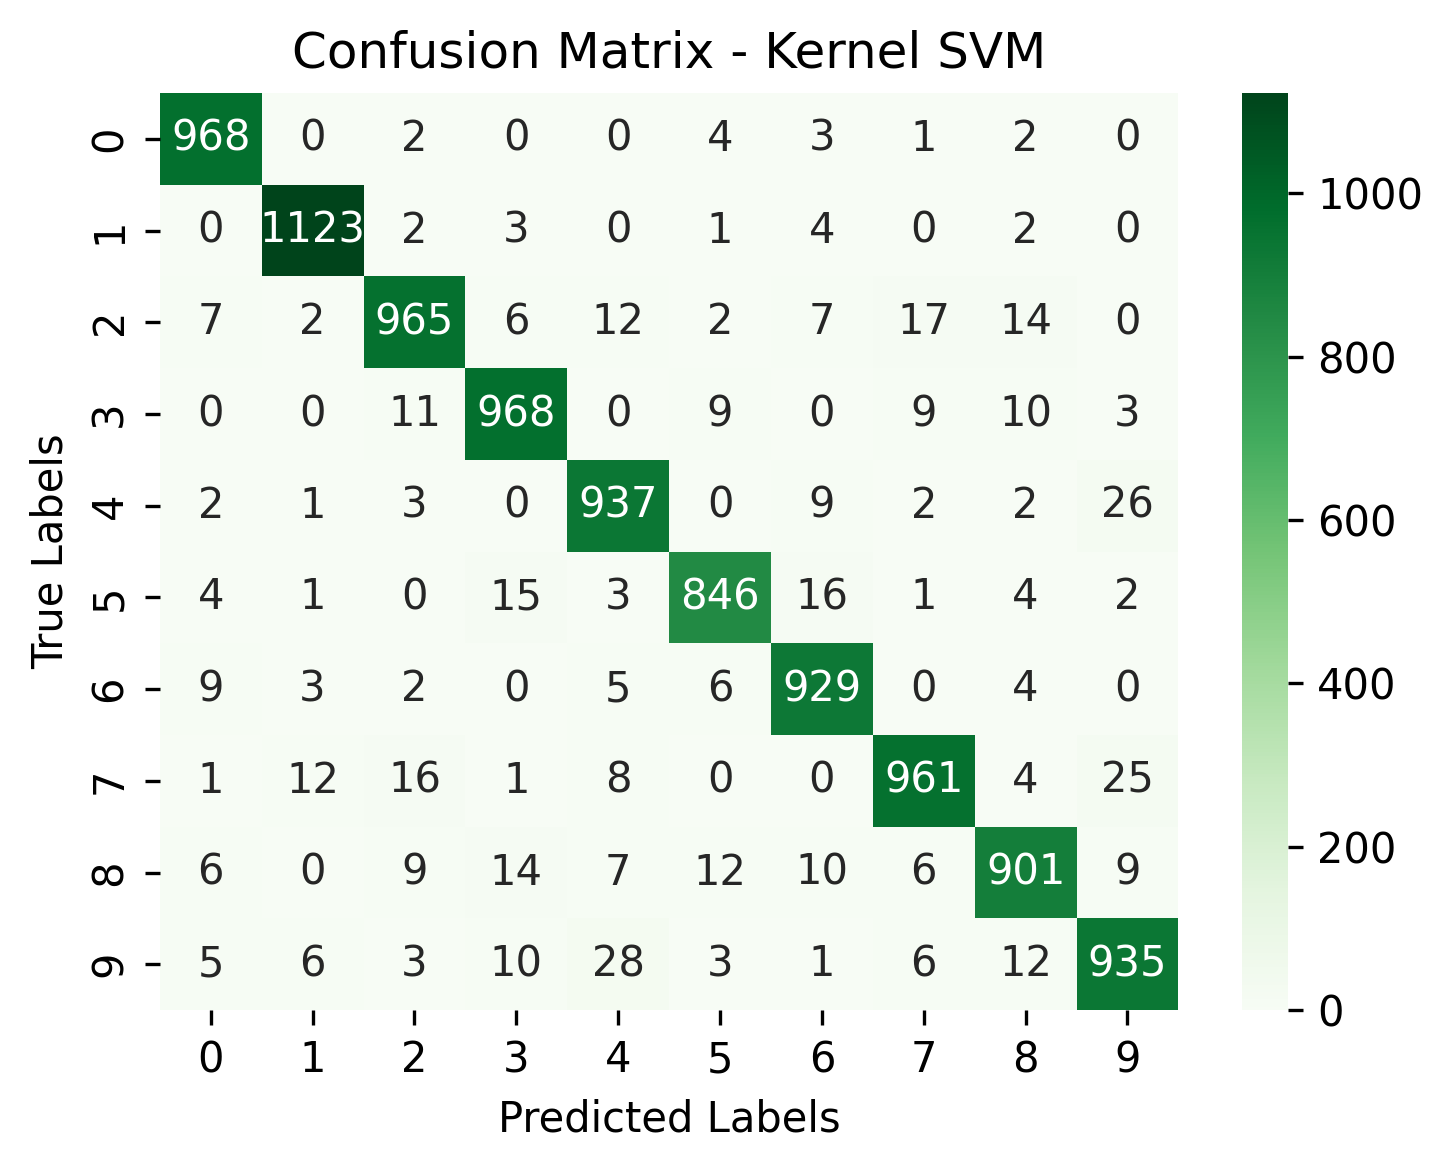

,precision,recall,f1-score
0,0.9555,0.9857,0.9704
1,0.9712,0.9806,0.9759
2,0.9516,0.9516,0.9516
3,0.9466,0.9475,0.9471
4,0.9526,0.9420,0.9473
5,0.9558,0.9462,0.9510
6,0.9406,0.9749,0.9575
7,0.9648,0.9339,0.9491
8,0.9569,0.9353,0.9460
9,0.9394,0.9366,0.9380


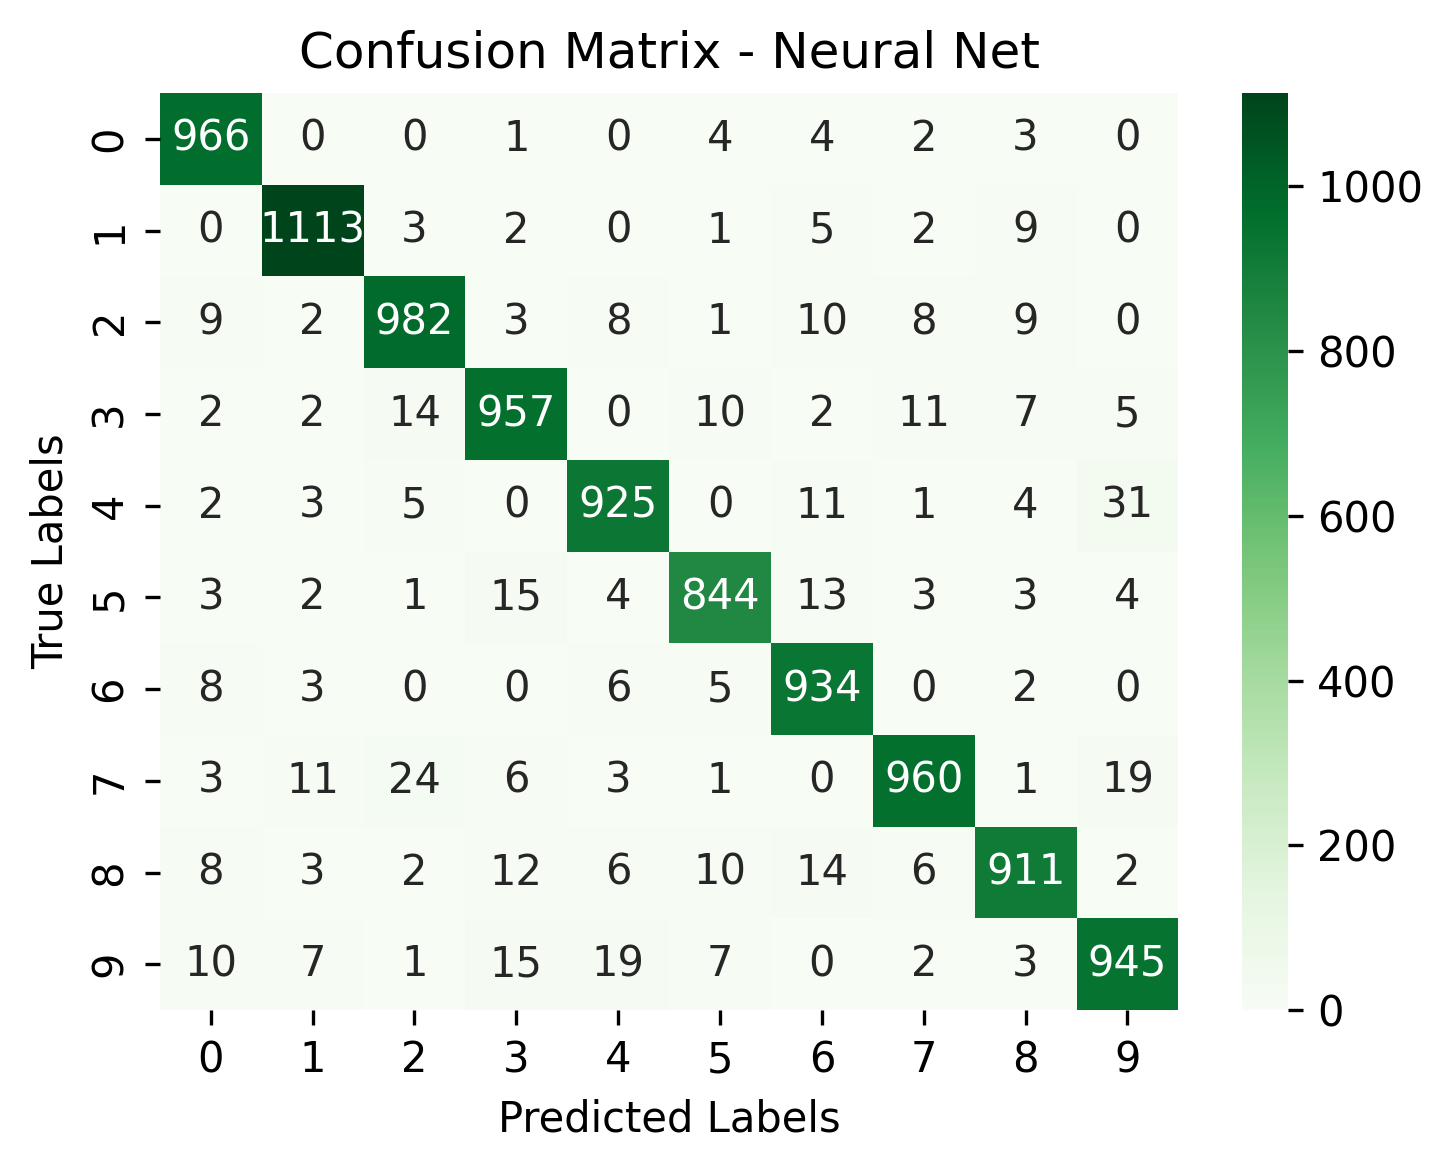

In [4]:
#|echo: false

classifier_results = pd.DataFrame()

for model in classification_models:
    # print(f"Running classification model: ---- {model} ----")
    result, _ = run_classifiers(model)
    classifier_results = pd.concat([classifier_results, result], ignore_index = True)

In [5]:
#|echo: false

display(classifier_results.style.hide(axis="index").set_caption("Evaluation Results of Classification Models").format(precision = 4))

Model,Training Accuracy,Testing Accuracy
KNN (5 clusters),0.9327,0.9305
Logistic Regression,0.9392,0.9260
Linear SVM,0.9141,0.9127
Kernel SVM,0.9523,0.9533
Neural Net,0.9578,0.9537


## 1.2

All classification models performed well with training and testing accuracies above 90%. Neural net and kernel SVM performed the best, with testing accuracies of 95.75% and 95.33%, respectively. The worst performing classification model was linear SVM with an accuracy of 91.27%. This difference makes sense since the MNIST data is not easily linearly separable.

Some models performed better than others due to their ability to capture the complex patterns in the MNIST dataset. For example, the neural net model with its multiple layers and non-linear activation functions can learn complex features and representations of the digit images. Kernel SVM also performed well because it uses a non-linear kernel function (like the radial basis function in this case) to project the data into a higher-dimensional space where it can be more easily separated.

In contrast, linear models such as linear SVM and logistic regression try to find a straight line or hyperplane that separates the classes. While logistic regression did slightly better due to its probabilistic approach, linear SVM struggled more because the data distribution in MNIST is inherently non-linear. KNN, which classifies based on the majority vote of the k-nearest neighbors, performed reasonably well but its accuracy is limited by the curse of dimensionality and sensitivity to irrelevant features.

Overall, models capable of capturing non-linear relationships (like neural nets and kernel SVM) are more suitable for the complex visual patterns found in this MNIST dataset.

# 2 - SVM

## 2.1
>**Question:** Explain why can we set the margin $c = 1$ to derive the SVM formulation? Justify using a mathematical proof.

To show why we can set the margin $c = 1$ to derive the SVM formulation, I can try proving that the following two expressions are equivalent:
$$
\begin{split}
\max_{w,b} & \frac{2c}{\|w\|}\\
\text{subject to } & y^i(w^Tx^i + b) \geq c, \forall i
\end{split}
\Leftrightarrow 
\begin{split}
\max_{w,b} & \frac{1}{\|w\|}\\
\text{subject to } & y^i(w^Tx^i + b) \geq 1, \forall i
\end{split}
$$

To simplify the derivation of the SVM formulation, we can set the margin to 1 to normalize the problem. The magnitude of $c$ is simply a scaling factor and does not change the classification results. 

Another way to see this is by using a mathematical proof to show the equivalence. We can divide $w^Tx^i$ and $b$ by any positive factor $\alpha$ in the constraint equation. This is the same as multiplying $c$ by $\alpha$ to keep the equations equivalent:
$$
y^i\left(\frac{w^Tx^i}{\alpha} + \frac{b}{\alpha}\right) \geq c
\Leftrightarrow 
y^i(w^Tx^i + b) \geq c \alpha
$$

We can choose $\alpha$ to be any positive number. In particular, we can choose $\alpha$ to be $1/c$ which would show:
$$
y^i(w^Tx^i c + b c) \geq c
$$
$$\text{or}$$ 
$$
y^i(w^Tx^i + b) \geq c \left(\frac{1}{c}\right)
$$

giving us the final expression, 
$$
y^i(w^Tx^i + b) \geq 1.
$$

Therefore, if $w$ and $b$ satisfy the margin constraints, scaling $w$ and $b$ by any positive factor $\alpha$ will also satisfy the constraints but will change the margin. By fixing the margin to 1, we remove this degree of freedom, leading to a unique solution. This condition ensures that each data point is correctly classified and lies on the correct side of the margin boundary with a minimum distance of 1 from the hyperplane.

## 2.2

> **Question**: Using Lagrangian dual formulation, show that the weight vector can be represented as
> $$
> w = \sum_{i=1}^n \alpha_i y_i x_i.
> $$
> where $\alpha_i \geq 0$ are the dual variables. What does this imply in terms of how to relate data to $w$?

The Lagrangian function is given by:
$$
L(w,b,\alpha) = \frac{1}{2} w^T w + \sum_{i=1}^n \alpha_i \left(1 - y_i (w^T x_i + b)\right)
$$ 

Taking the derivative, setting it to zero, and solving for $w$: 
$$
\frac{\partial L(w,b,\alpha)}{\partial w} = w - \sum_{i=1}^n \alpha_iy_i x_i = 0 
$$
$$
w = \sum_{i=1}^n \alpha_iy_i x_i
$$ 

This shows that the weight vector can be represented as the expression above and implies that the weight vector is a linear combination of the feature vectors.


## 2.3 

> **Question:** Explain why only the data points on the `margin` will contribute to the sum above, i.e., playing a role in defining $w$. Hint: use the Lagrangian multiplier derivation and KKT condition we discussed in class. 

The KKT condition specifies that the criteria for the saddle point $L$ must satisfy the constraint: 
$$
\alpha_i \left(1 - y_i (w^T x_i + b)\right) = 0
$$

This constraint implies that for each training data point $(x_i, y_i)$, either $\alpha_i = 0$ or $(1 - y_i (w^T x_i + b)) = 0$.

- For points where $\alpha_i = 0$:
  $$
  \alpha_i \left(1 - y_i (w^T x_i + b) \right) = 0 \implies \alpha_i = 0
  $$
  These points do not contribute to the weight vector $w$ because their corresponding Lagrangian multiplier $\alpha_i$ is zero.

- For points where $1 - y_i (w^T x_i + b) = 0$:
  $$
  y_i (w^T x_i + b) = 1
  $$
  These points lie exactly on the margin, meaning they are the support vectors. For these points, $\alpha_i$ can be greater than zero and so they contribute to the weight vector $w$.

Therefore, only the data points on the margin contribute to the weight vector $w$. The constraint above ensures that only the points on the margin (the support vectors) have non-zero $\alpha_i$ and contribute to the sum $w = \sum_{i=1}^n \alpha_i y_i x_i$. Points that are not on the margin will have $\alpha_i = 0$ and do not affect the weight vector. This is why the support vectors are critical in defining the decision boundary in an SVM.


## 2.4 
> Simple SVM by hand. 
> 
> Suppose we only have four training examples in two dimensions as shown in Figure 1. The positive samples are at $x_1 = (0, 0)$ and $x_2 = (2, 2)$, while the negative samples are at $x_3 = (h, 1)$ and $x_4 = (0, 3)$.

![SVM Plot](svm.png){width=70%}

### 2.4.a

> **Question:** Given $h>0$, For what range of parameter h are the training points still linearly separable?

To determine the boundary that separates the two classes, we first identify the line that connects the two positive samples, $(0,0)$ and $(2,2)$. The equation of this line is $y = x$. For the training points to remain linearly separable, all negative points must lie on the left side of this line.

Considering the negative point at $(0,3)$, any other negative point must satisfy the condition $y < x$ to ensure linear separability. If the y-coordinate of the other negative point is set to 1, then for this point to be on the left of the line $y = x$, it must hold that $h < 1$.

![SVM Boundary](outputs/SVM_boundary.png){width=50%}

This constraint is illustrated in the plot above which visually explains why $h$ must be less than 1. This [animation](outputs/SVM_animation.gif) further shows the values that $h$ can be.

### 2.4.b

> **Question:** Does the orientation of the maximum margin decision boundary change as $h$ changes, when the points are separable? Please explain your conclusion.

The orientation of the maximum margin decision boundary does not change as $h$ changes and will always be paralell to the line $y = x$. The decision boundary is determined by the support vectors which are the points closest to the boundary. As long as $h < 1$, the support vectors remain the same, specifically the positive points $(0,0)$ and $(2,2)$, and the negative point $(0,3)$. Therefore, the orientation of the boundary which is along the line $y = x$ stays constant.


# 3 - Neural networks and backpropagation

Consider a simple two-layer network from the lecture slides. Given $m$ training data $(x^i, y^i)$, $i = 1, \ldots, m$, the cost function used in training the neural networks is given by
$$
\ell(w, \alpha, \beta) = \sum_{i=1}^m (y^i - \sigma(w^T z^i))^2
$$
where $\sigma (x) = 1/(1+e^{-x})$ is the sigmoid function, $z^i$ is a two-dimensional vector such that $z_1^i = \sigma(\alpha^T x^i)$, and $z_2^i = \sigma(\beta^T x^i)$.

## 3.1 

> **Question:** Show that the gradient is given by
> $$
> \frac{\partial \ell(w, \alpha, \beta) }{\partial w}
> = - \sum_{i=1}^m 2(y^i - \sigma(u^i))\sigma(u^i)(1-\sigma(u^i)) z^i,
> $$
> where $u^i = w^T z^i$.

The cost function is given by:
$$ 
\ell(w, \alpha, \beta) = \sum_{i=1}^m (y^i - \sigma(w^T z^i))^2
$$

Taking the partial derivative with respect to $w$ and applying the chain rule:
$$ 
\frac{\partial \ell(w, \alpha, \beta)}{\partial w} = \sum_{i=1}^m 2(y^i - \sigma(w^T z^i)) \frac{\partial}{\partial w} \left( y^i - \sigma(w^T z^i) \right)
$$

Regarding the derivative from the chain rule, we get the simplified form below since $y^i$ is a constant:
$$ 
\frac{\partial}{\partial w} \left( y^i - \sigma(w^T z^i) \right) = - \frac{\partial}{\partial w} \sigma(w^T z^i)
$$

The derivative of the sigmoid function $\sigma(x)$ with respect to $x$ is:
$$ 
\sigma(x) = (1 + e^{-x})^{-1}
$$
$$ 
\frac{d\sigma(x)}{dx} = \frac{e^{-x}}{(1 + e^{-x})^2}
$$
$$ 
\sigma(x) = \frac{1}{1 + e^{-x}} \implies e^{-x} = \frac{1 - \sigma(x)}{\sigma(x)}
$$
$$ 
\frac{d\sigma(x)}{dx} = \frac{\frac{1 - \sigma(x)}{\sigma(x)}}{\left( \frac{1}{\sigma(x)} \right)^2}
$$
$$
\sigma'(x) = \sigma(x) (1 - \sigma(x))
$$

Since $u^i = w^T z^i$, $\sigma(u^i) = \sigma(w^T z^i)$. Using the chain rule, the derivative of $\sigma(w^T z^i)$ with respect to $w$ is:
$$ 
\frac{\partial \sigma(w^T z^i)}{\partial w} = \sigma'(u^i) \frac{\partial u^i}{\partial w} = \sigma(u^i)(1 - \sigma(u^i)) z^i
$$

Now, I can substitute this result back into the expression for the gradient:
$$ 
\frac{\partial \ell(w, \alpha, \beta)}{\partial w} = \sum_{i=1}^m 2(y^i - \sigma(u^i)) \left( -\sigma(u^i)(1 - \sigma(u^i)) z^i \right)
$$

Simplifying, we get:
$$ 
\boxed{ \frac{\partial \ell(w, \alpha, \beta)}{\partial w} = \sum_{i=1}^m -2(y^i - \sigma(u^i)) \sigma(u^i)(1 - \sigma(u^i)) z^i }
$$

## 3.2

> **Question:** Also, show the gradient of $\ell(w, \alpha, \beta)$ with respect to $\alpha$ and $\beta$ and write down their expression.


**Gradient with Respect to $\alpha$**

Chain rule for differentiation:
$$ 
\frac{\partial \ell}{\partial \alpha} = \sum_{i=1}^m \frac{\partial \ell}{\partial z_1^i} \cdot \frac{\partial z_1^i}{\partial \alpha}
$$
$$ 
\frac{\partial \ell}{\partial z_1^i} = -2(y^i - \sigma(u^i)) \sigma(u^i)(1 - \sigma(u^i)) w_1
$$
where $w_1$ is the first component of the weight vector $w$.
$$ 
\frac{\partial z_1^i}{\partial \alpha} = \sigma'(\alpha^T x^i) x^i = \sigma(\alpha^T x^i)(1 - \sigma(\alpha^T x^i)) x^i
$$

Combining these, we get:
$$ 
\frac{\partial \ell}{\partial \alpha} = - \sum_{i=1}^m 2(y^i - \sigma(u^i)) \sigma(u^i)(1 - \sigma(u^i)) w_1 \cdot \sigma(\alpha^T x^i)(1 - \sigma(\alpha^T x^i)) x^i
$$


**Gradient with Respect to $\beta$**

Chain rule for differentiation:
$$ 
\frac{\partial \ell}{\partial \beta} = \sum_{i=1}^m \frac{\partial \ell}{\partial z_2^i} \cdot \frac{\partial z_2^i}{\partial \beta}
$$
$$ 
\frac{\partial \ell}{\partial z_2^i} = -2(y^i - \sigma(u^i)) \sigma(u^i)(1 - \sigma(u^i)) w_2
$$
where $w_2$ is the second component of the weight vector $w$.
$$ 
\frac{\partial z_2^i}{\partial \beta} = \sigma'(\beta^T x^i) x^i = \sigma(\beta^T x^i)(1 - \sigma(\beta^T x^i)) x^i
$$

Combining these, we get:
$$ 
\frac{\partial \ell}{\partial \beta} = - \sum_{i=1}^m 2(y^i - \sigma(u^i)) \sigma(u^i)(1 - \sigma(u^i)) w_2 \cdot \sigma(\beta^T x^i)(1 - \sigma(\beta^T x^i)) x^i
$$

Therefore, the gradients of $\ell(w, \alpha, \beta)$ with respect to $\alpha$ and $\beta$ are:
$$ 
\boxed{ \frac{\partial \ell}{\partial \alpha} = - \sum_{i=1}^m 2(y^i - \sigma(u^i)) \sigma(u^i)(1 - \sigma(u^i)) w_1 \cdot \sigma(\alpha^T x^i)(1 - \sigma(\alpha^T x^i)) x^i }
$$
$$ 
\boxed{ \frac{\partial \ell}{\partial \beta} = - \sum_{i=1}^m 2(y^i - \sigma(u^i)) \sigma(u^i)(1 - \sigma(u^i)) w_2 \cdot \sigma(\beta^T x^i)(1 - \sigma(\beta^T x^i)) x^i }
$$

# 4 - Feature selection and change-point detection

## 4.1

> **Question:** Consider the mutual information-based feature selection. Suppose we have the following table (the entries in the table indicate counts) for the spam versus and non-spam emails:
> 
> $$
> \begin{array}{c|c|c}
> \hline
>  & \text{``prize'' = 1} & \text{``prize'' = 0} \\
> \hline
> \text{``spam'' = 1} & 150 & 10 \\
> \hline
> \text{``spam'' = 0} & 1000 & 15000 \\
> \hline
> \end{array}
> $$
> 
> $$
> \begin{array}{c|c|c}
> \hline
>  & \text{``hello'' = 1} & \text{``hello'' = 0} \\
> \hline
> \text{``spam'' = 1} & 145 & 15 \\
> \hline
> \text{``spam'' = 0} & 11000 & 5000 \\
> \hline
> \end{array}
> $$
> 
> Given the two tables above, calculate the mutual information for the two keywords, "prize" and "hello" respectively. Which keyword is more informative for deciding whether or not the email is spam? If any tools are used for your calculation, you must still show your mathematical steps in your report and include code/files used for your calculations.

The mutual information value can be calculated using the equation,
$$
\begin{split}
I(U;C) &= \frac{N_{11}}{N} \log_2 \left( \frac{N \cdot N_{11}}{(N_{11} + N_{10})(N_{11} + N_{01})} \right) + \frac{N_{01}}{N} \log_2 \left( \frac{N \cdot N_{01}}{(N_{01} + N_{00})(N_{11} + N_{01})} \right) \\
&\quad + \frac{N_{10}}{N} \log_2 \left( \frac{N \cdot N_{10}}{(N_{11} + N_{10})(N_{10} + N_{00})} \right) + \frac{N_{00}}{N} \log_2 \left( \frac{N \cdot N_{00}}{(N_{01} + N_{00})(N_{10} + N_{00})} \right)
\end{split}
$$
where

- $N = N_{11} + N_{10} + N_{01} + N_{00}$ (the total number of samples)
- $N_{11}$ is the count of samples where the message is spam and the keyword is present
- $N_{10}$ is the count of samples where the message is spam and the keyword is not present 
- $N_{01}$ is the count of samples where the message is not spam and the keyword is present 
- $N_{00}$ is the count of samples where the message is not spam and the keyword is not present

I converted the given tables into dictionaries and the equation above into code using Python, allowing me to efficiently and accurately calculate the mutual information values. This implantation is shown below.  

In [6]:
#|echo: false

# table from module 12 to test mutual_information_value function
test_table = {
    'N11': 49,
    'N10': 27652,
    'N01': 141,
    'N00': 774106
}

In [7]:
prize_table = {
    'N11': 150,
    'N10': 10,
    'N01': 1000,
    'N00': 15000
}
hello_table = {
    'N11': 145,
    'N10': 15,
    'N01': 11000,
    'N00': 5000
}

def mutual_information_value(table, keyword):
    N11 = table['N11']
    N10 = table['N10']
    N01 = table['N01']
    N00 = table['N00']

    total = sum([N11, N10, N01, N00])
    
    mi_value = (N11/total)*math.log2(total*N11/((N11+N10)*(N11+N01))) + \
               (N01/total)*math.log2(total*N01/((N01+N00)*(N11+N01))) + \
               (N10/total)*math.log2(total*N10/((N11+N10)*(N10+N00))) + \
               (N00/total)*math.log2(total*N00/((N01+N00)*(N10+N00)))

    print(f'Keyword: "{keyword}" - Mutual information value: {round(mi_value, 8)}')

mutual_information_value(prize_table, 'Prize')
mutual_information_value(hello_table, 'Hello')

Keyword: "Prize" - Mutual information value: 0.03296012
Keyword: "Hello" - Mutual information value: 0.00194804


As seen from the outputs above, the keyword "prize" has a higher mutual information value than the keyword "hello" (0.032960 vs 0.001948). This means that the presence or absence of the keyword "prize" provides more information about whether an email is spam or not than the presence or absence of the keyword "hello". Therefore, the keyword "prize" is more informative for deciding whether or not the email is spam.

## 4.2

> **Question:**  Given two distributions, $f_0 = \mathcal{N}(0.1, 1)$, $f_1 = \mathcal{N}(0.5, 1.5)$, derive what should be the CUSUM statistic (i.e., show the mathematical CUSUM detection statistic specific to these distributions). Plot the CUSUM statistic for a sequence of 150 randomly generated i.i.d. (independent and identically distributed) samples, $x_1, \ldots, x_{100}$ according to $f_0$ and $x_{101}, \ldots, x_{150}$ according to $f_1$. Please provide a reasonable estimation based solely on your plot of where a change may be detected.

The CUSUM statistic is used for detecting changes in the distribution of a process and is defined as:
$$ 
W_0 = 0 
$$
$$ 
W_t = \max \left( W_{t-1} + \log \left( \frac{f_1(X_t)}{f_0(X_t)} \right), 0 \right) 
$$

The probability density function of a normal distribution is:
$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( {-\frac{(x-\mu)^2}{2\sigma^2}} \right) 
$$

- For $f_0 = \mathcal{N}(0.1, 1)$:
$$
f_0(x) = \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{(x - 0.1)^2}{2} \right) 
$$

- For  $f_1 = \mathcal{N}(0.5, 1.5)$:
$$
f_1(x) = \frac{1}{\sqrt{3\pi}} \exp \left( -\frac{(x - 0.5)^2}{3} \right) 
$$

Calculating the log-likelihood ratio:
$$
\log \left( \frac{f_1(X_t)}{f_0(X_t)} \right) = \log \left( \frac{\frac{1}{\sqrt{3\pi}} \exp \left( -\frac{(x_t - 0.5)^2}{3} \right)}{\frac{1}{\sqrt{2\pi}} \exp \left( -\frac{(x_t - 0.1)^2}{2} \right)} \right) 
$$
$$
= \log \left( \frac{1}{\sqrt{3\pi}} \right) - \frac{(x_t - 0.5)^2}{3} - \log \left( \frac{1}{\sqrt{2\pi}} \right) + \frac{(x_t - 0.1)^2}{2} 
$$
$$
= -\frac{1}{2} \log(3) - \frac{(x_t - 0.5)^2}{3} + \frac{1}{2} \log(2) + \frac{(x_t - 0.1)^2}{2} 
$$

Simplifying further:
$$
= \frac{1}{2} \log\left(\frac{2}{3}\right) + \frac{(x_t - 0.1)^2}{2} - \frac{(x_t - 0.5)^2}{3}
$$

Therefore:
$$ 
W_t = \max \left( W_{t-1} + \left( \frac{1}{2} \log\left(\frac{2}{3}\right) + \frac{(x_t - 0.1)^2}{2} - \frac{(x_t - 0.5)^2}{3} \right), 0 \right) 
$$

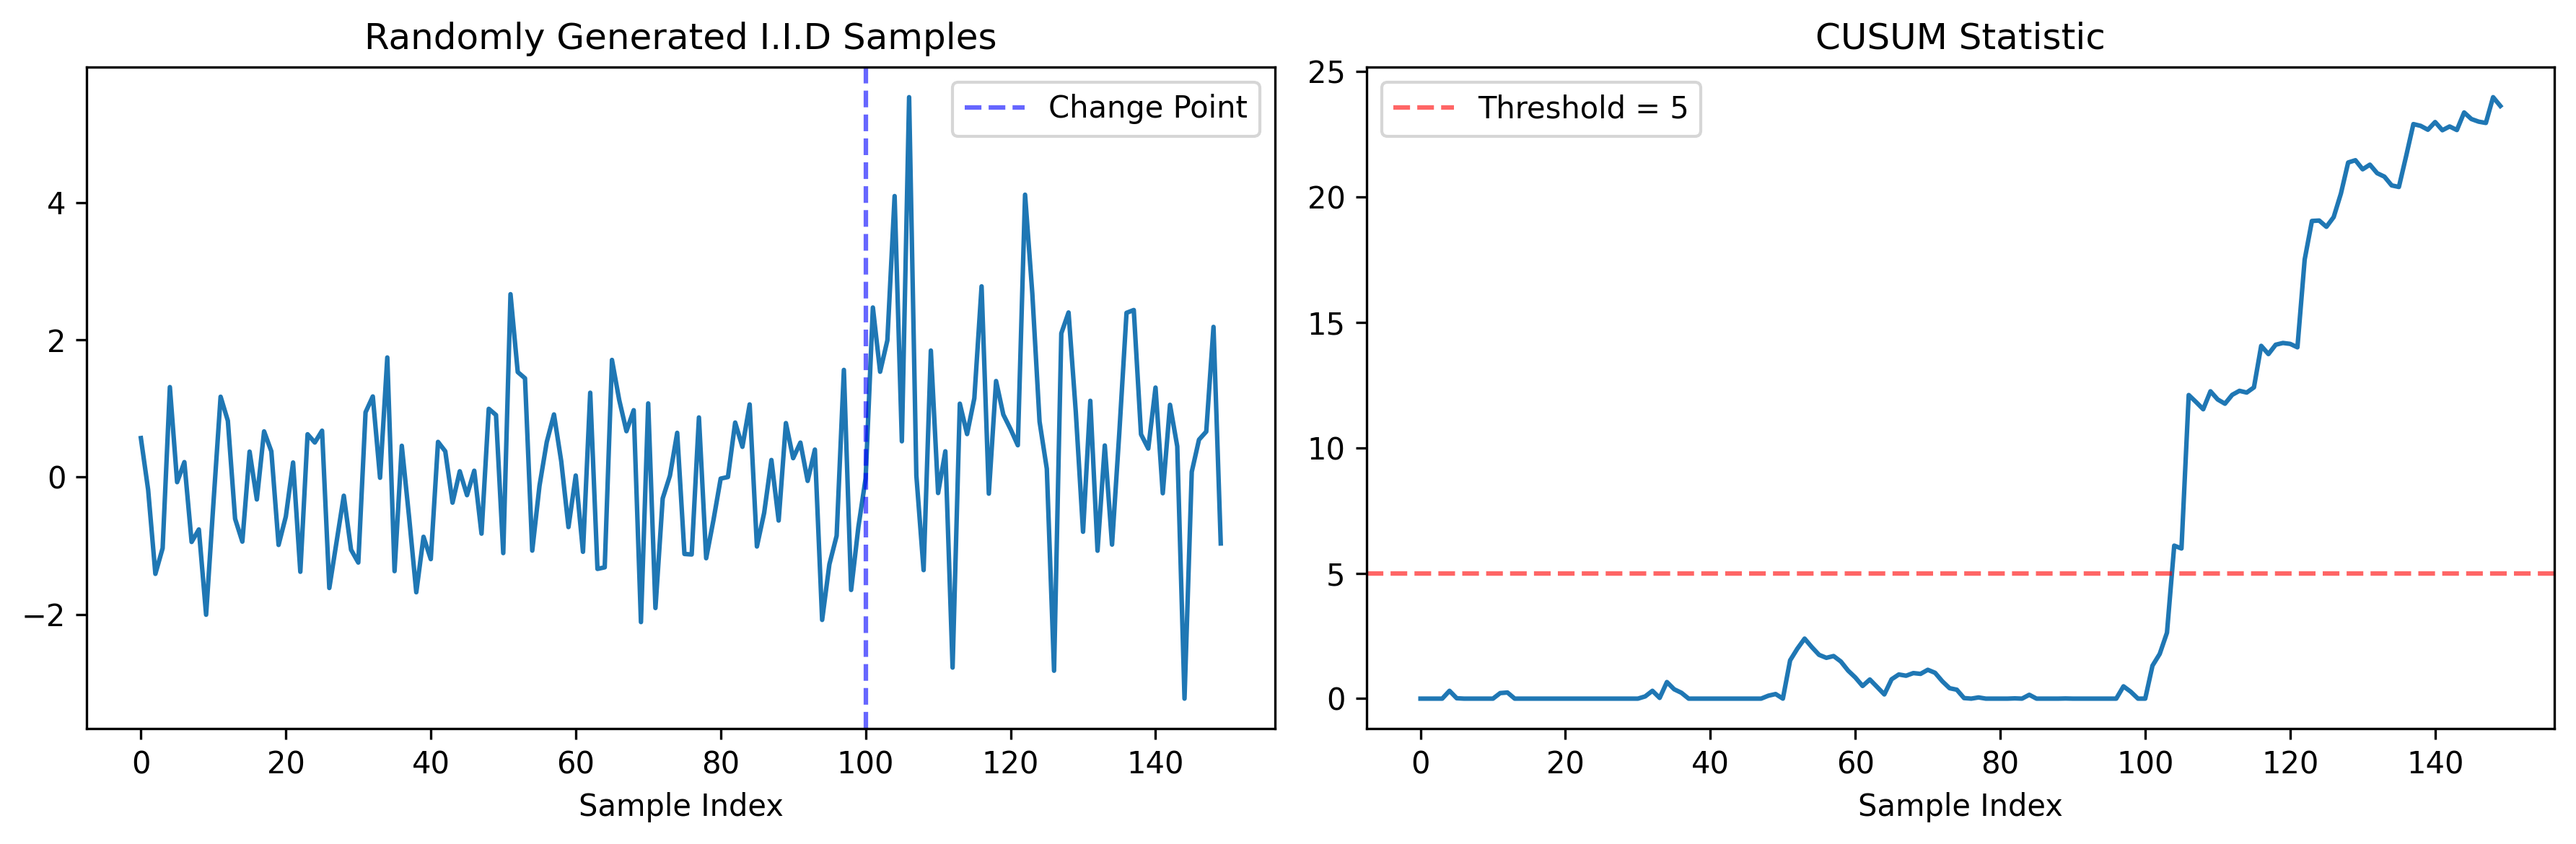

In [8]:
#|echo: false

# generate the samples
seed = 123456
np.random.seed(seed)
f0 = np.random.normal(0.1, 1, 100)
f1 = np.random.normal(0.5, 1.5, 50)

def plot_cusum(sample1, sample2, threshold = 5):

    x = np.concatenate([sample1, sample2])

    # log-likelihood ratio
    ll_ratio = np.zeros_like(x)
    for i in range(len(x)):
        ll_ratio[i] = (1/2) * np.log(2/3) + ((x[i] - 0.1)**2 / 2) - ((x[i] - 0.5)**2 / 3)

    # CUSUM statistic
    S = np.zeros_like(x)
    for i in range(1, len(x)):
        S[i] = max(0, S[i-1] + ll_ratio[i])
    
    # print(max(S[:101]))
    
    # plot the samples and the CUSUM statistic
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(x)
    ax1.axvline(x = 100, color = 'b', linestyle = '--', label = 'Change Point', alpha = 0.6)
    ax1.set_xlabel('Sample Index')
    ax1.set_title('Randomly Generated I.I.D Samples')
    ax1.legend()

    ax2.plot(S)
    ax2.axhline(y = threshold, color = 'r', linestyle = '--', label = f'Threshold = {threshold}', alpha = 0.6)
    ax2.set_xlabel('Sample Index')
    ax2.set_title('CUSUM Statistic')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_cusum(f0, f1, threshold = 5)

Based on the plot of the CUSUM statistic above, we can see a significant increase in the CUSUM statistic around the sample index 100 where the distribution changes from $f_0$ to $f_1$. A reasonable rule for detecting the CUSUM change point would be to set a threshold value of 5 and declare a change in the distribution when the CUSUM statistic exceeds this threshold. Since this threshold is double the previous high (~2.4) from the first sample, it should be sufficient enough to declare a change once the CUSUM statistic surpasses it. 

# 5 - Medical imaging reconstruction

In this problem, I will consider an example that resembles medical imaging reconstruction in MRI. We begin with a true image image of dimension 50 $\times$ 50 (i.e., there are 2500 pixels in total). Data is stored in the file `cs.mat` and can be plotted first. This image is truly sparse, in the sense that 2084 of its pixels have a value of 0, while 416 pixels have a value of 1. We can think of this image as a toy version of an MRI image that we are interested in collecting.

Because of the nature of the machine that collects the MRI image, it takes a long time to measure each pixel value individually, but it's faster to measure a linear combination of pixel values. We measure $n$ = 1300 linear combinations, with the weights in the linear combination being random, in fact, independently distributed as $\mathcal{N}(0,1)$. Because the machine is not perfect, we don't get to observe this directly, but we observe a noisy version. These measurements are given by the entries of the vector
$$
y = A x + \epsilon,
$$
where $y \in \mathbb R^{1300}$, $A \in \mathbb R^{1300\times 2500}$, and $\epsilon \sim \mathcal N(0, 25\times I_{1300})$ where $I_n$ denotes the identity matrix of size $n\times n$. In this homework, we can generate the data $y$ using this model. 

Now the question is: can we model $y$ as a linear combination of the columns of $x$ to recover some coefficient vector that is close to the image? Roughly speaking, the answer is yes. 

Key points here: although the number of measurements $n$ = 1300 is smaller than the dimension $p$ = 2500, the true image is sparse. Thus we can recover the sparse image using few measurements exploiting its structure. This is the idea behind the field of *compressed sensing*. 

The image recovery can be done using lasso
$$
\min_x \|y-Ax\|_2^2 + \lambda \|x\|_1.
$$

## 5.1 

> **Question:** Now use lasso to recover the image and select $\lambda$ using 10-fold cross-validation. Plot the cross-validation error curves, and show the recovered image using your selected lambda values.


In [9]:
#|echo: false

data = scipy.io.loadmat('data/cs.mat')['img']

In [10]:
#|echo: false

seed = 123456
np.random.seed(seed)

A = np.random.randn(1300, 2500) # A is 1300x2500
x = data.reshape(-1) 
eps = np.random.normal(0, np.sqrt(25), (1300,)) # eps is Norm(0, 25 * I) where I is nxn and n = 1300

y = A.dot(x) + eps

In [11]:
#|echo: false

def run_LassoCV(folds = 10):
    # lasso with 10-fold cv
    lasso_cv = LassoCV(cv = folds, random_state = seed)
    lasso_cv.fit(A, y)
    
    return lasso_cv.alphas_, lasso_cv.mse_path_, lasso_cv.alpha_

lasso_alphas, lasso_mses, best_lasso_alpha = run_LassoCV(folds = 10)

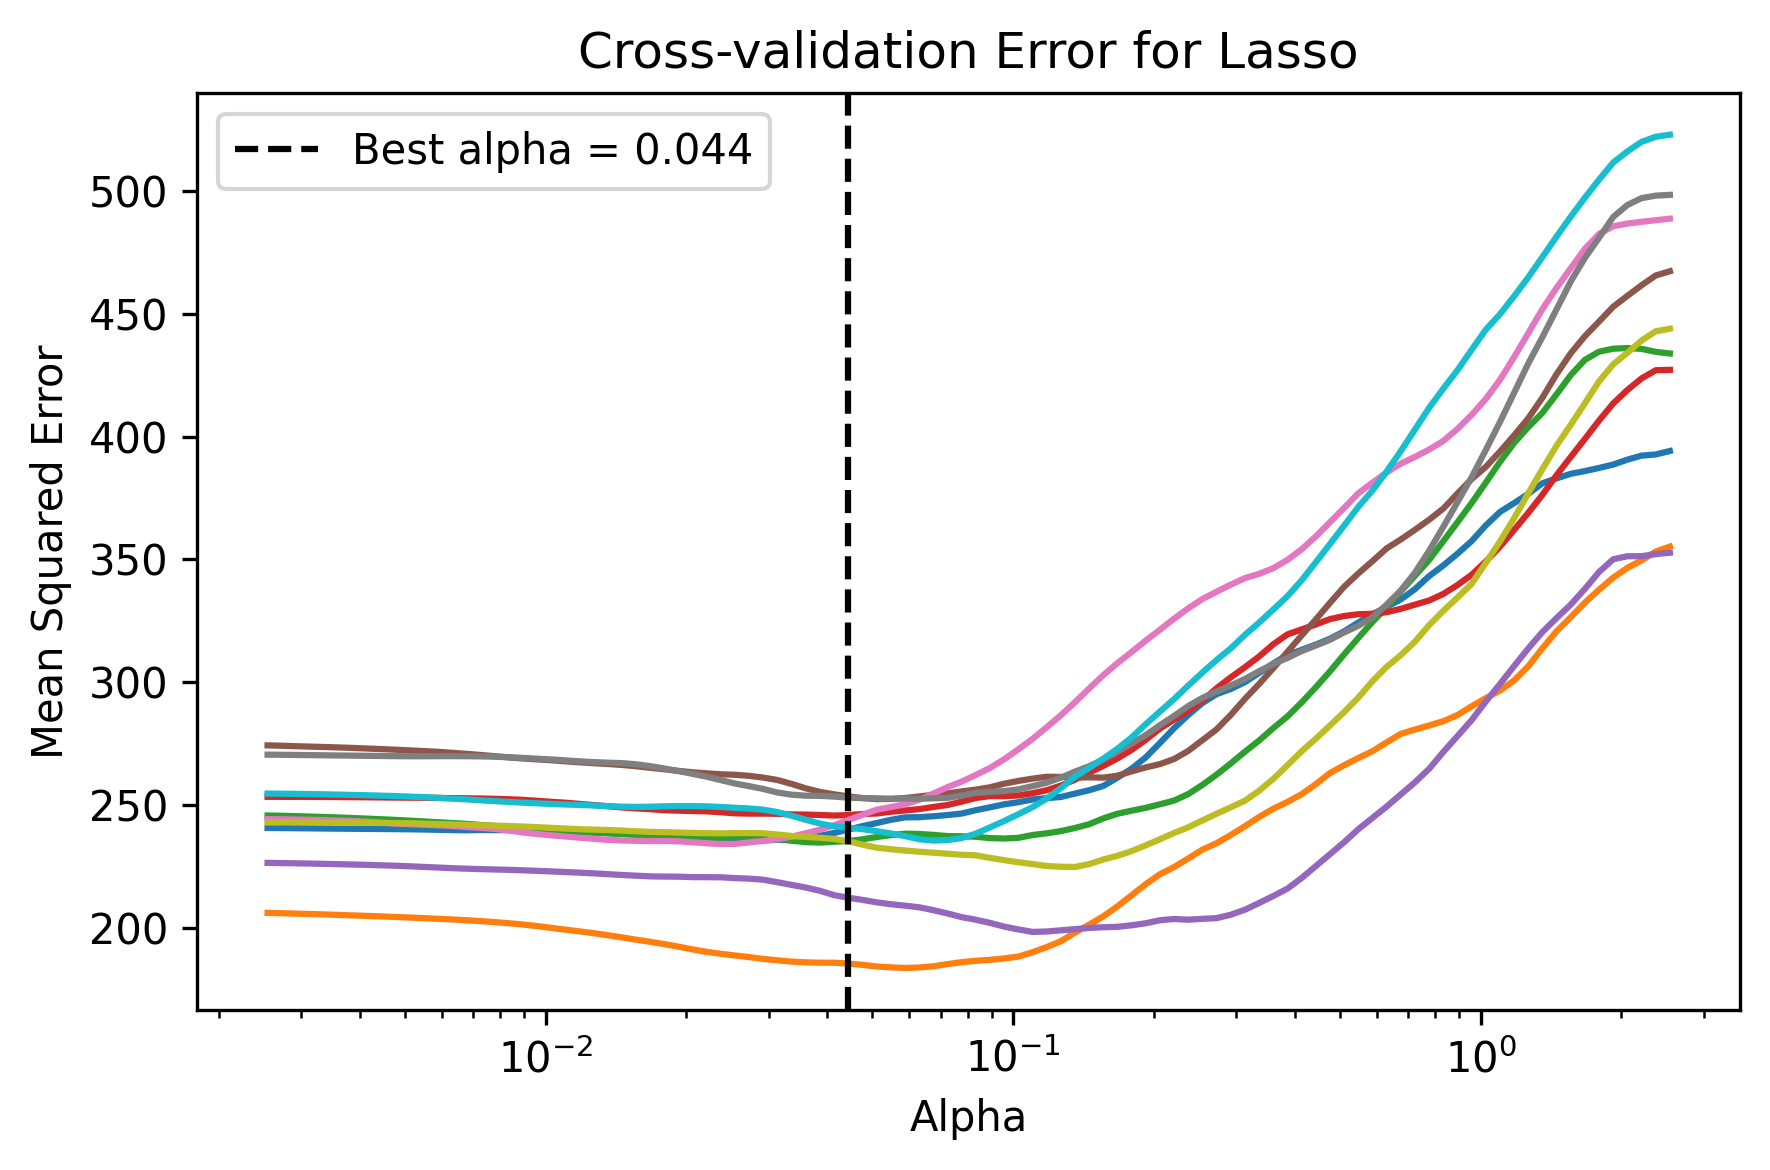

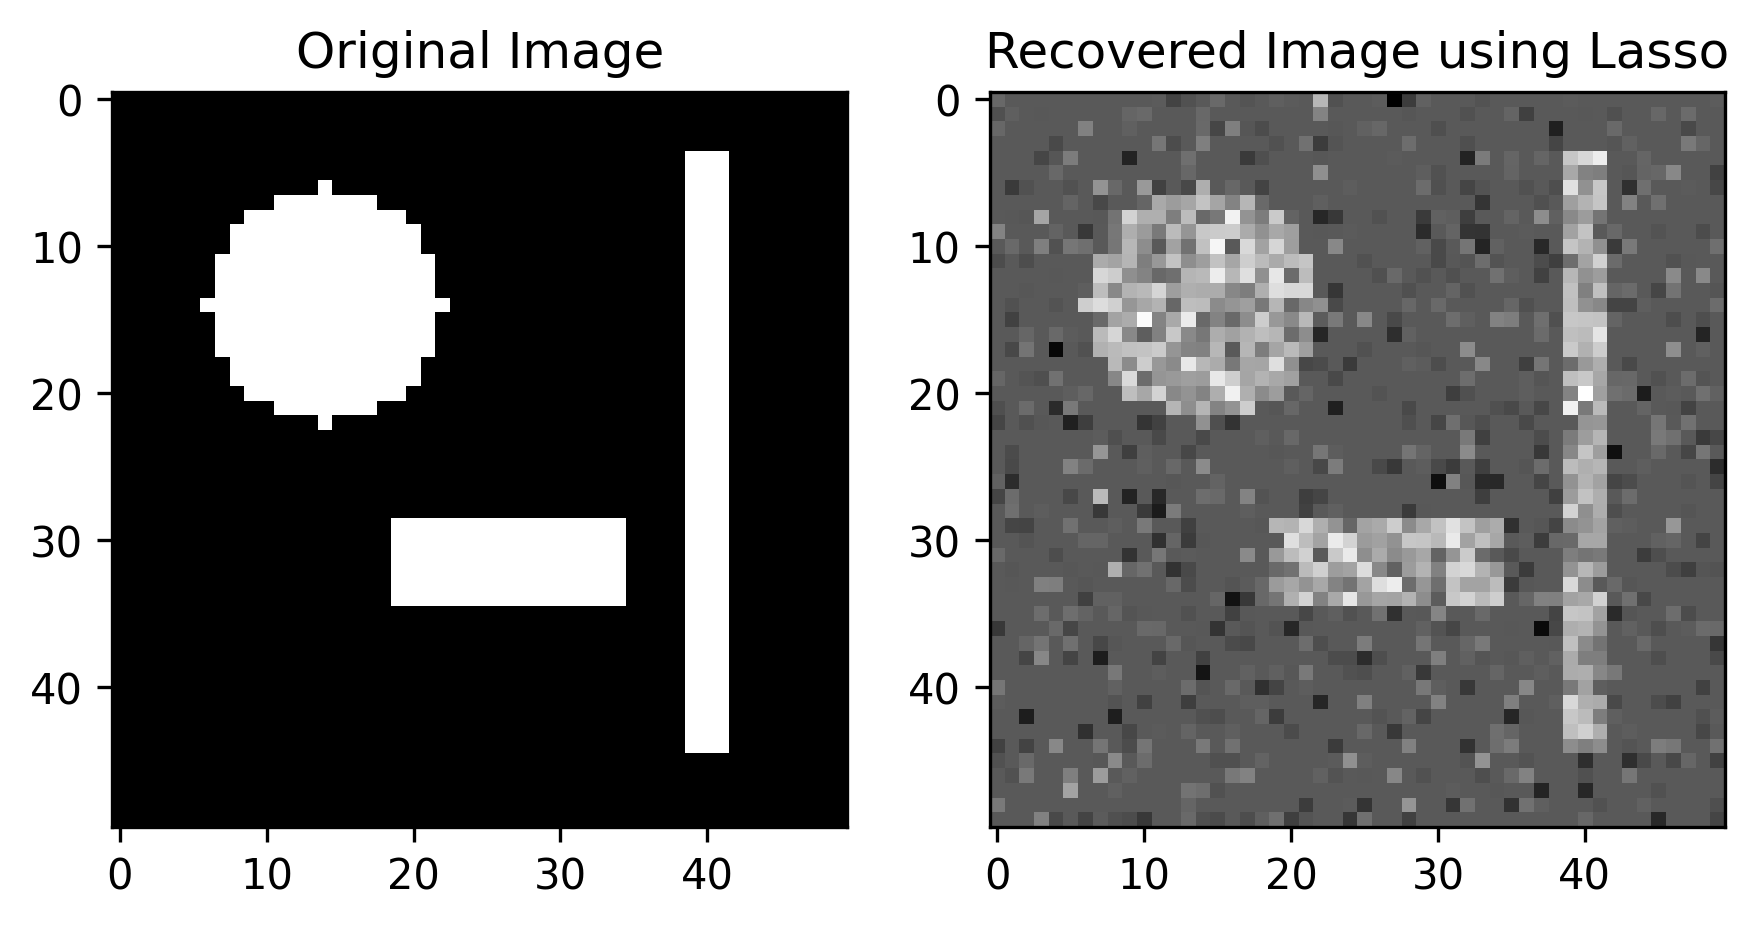

In [12]:
#|echo: false

def plot_lasso_ridge(alphas, mses, best_alpha, title, model):

    # cv error curves
    plt.figure(figsize = (6,4))
    plt.semilogx(alphas, mses)
    plt.axvline(best_alpha, linestyle = '--', color = 'k', label = f'Best alpha = {best_alpha:.3f}')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Cross-validation Error for {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # print(f'{title} - Best lambda (alpha): {best_alpha}')

    # recover the image using the best alpha
    lasso_best = model(alpha = best_alpha)
    lasso_best.fit(A, y)
    x_recovered = lasso_best.coef_
    img_recovered = x_recovered.reshape((50, 50))

    # plt.figure(figsize = (4,3))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

    ax1.imshow(data, cmap = 'gray')
    ax1.set_title("Original Image")
    ax2.imshow(img_recovered, cmap = 'gray')
    ax2.set_title(f'Recovered Image using {title}')
    
    plt.tight_layout()
    plt.show()

plot_lasso_ridge(lasso_alphas, lasso_mses, best_lasso_alpha, title = 'Lasso', model = Lasso)

## 5.2

> **Question:** To compare, also use ridge regression to recover the image:
> $$
> \min_x \|y-Ax\|_2^2 + \lambda \|x\|_2^2.
> $$
> Select $\lambda$ using 10-fold cross-validation. Plot the cross-validation error curves, and show the recovered image using your selected lambda values. Which approaches give a better recovered image?

In [15]:
#|echo: false
#|output: false

def run_RidgeCV(folds = 10):

    # Ridge regression with 10-fold cv
    ridge_alphas = np.arange(start = 0, stop = 1000, step = 5)
    ridge = Ridge()
    
    # grid search with cv
    ridge_gs = GridSearchCV(ridge, {'alpha': ridge_alphas}, 
                            scoring = 'neg_mean_squared_error', 
                            cv = folds, 
                            n_jobs = -1,
                            verbose = 2)
    ridge_gs.fit(A, y)

    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

    ridge_mses = -ridge_gs.cv_results_['mean_test_score']
    best_ridge_alpha = ridge_gs.best_params_['alpha']
    
    return ridge_alphas, ridge_mses, best_ridge_alpha

ridge_alphas, ridge_mses, best_ridge_alpha = run_RidgeCV(folds = 10)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


KeyboardInterrupt: 

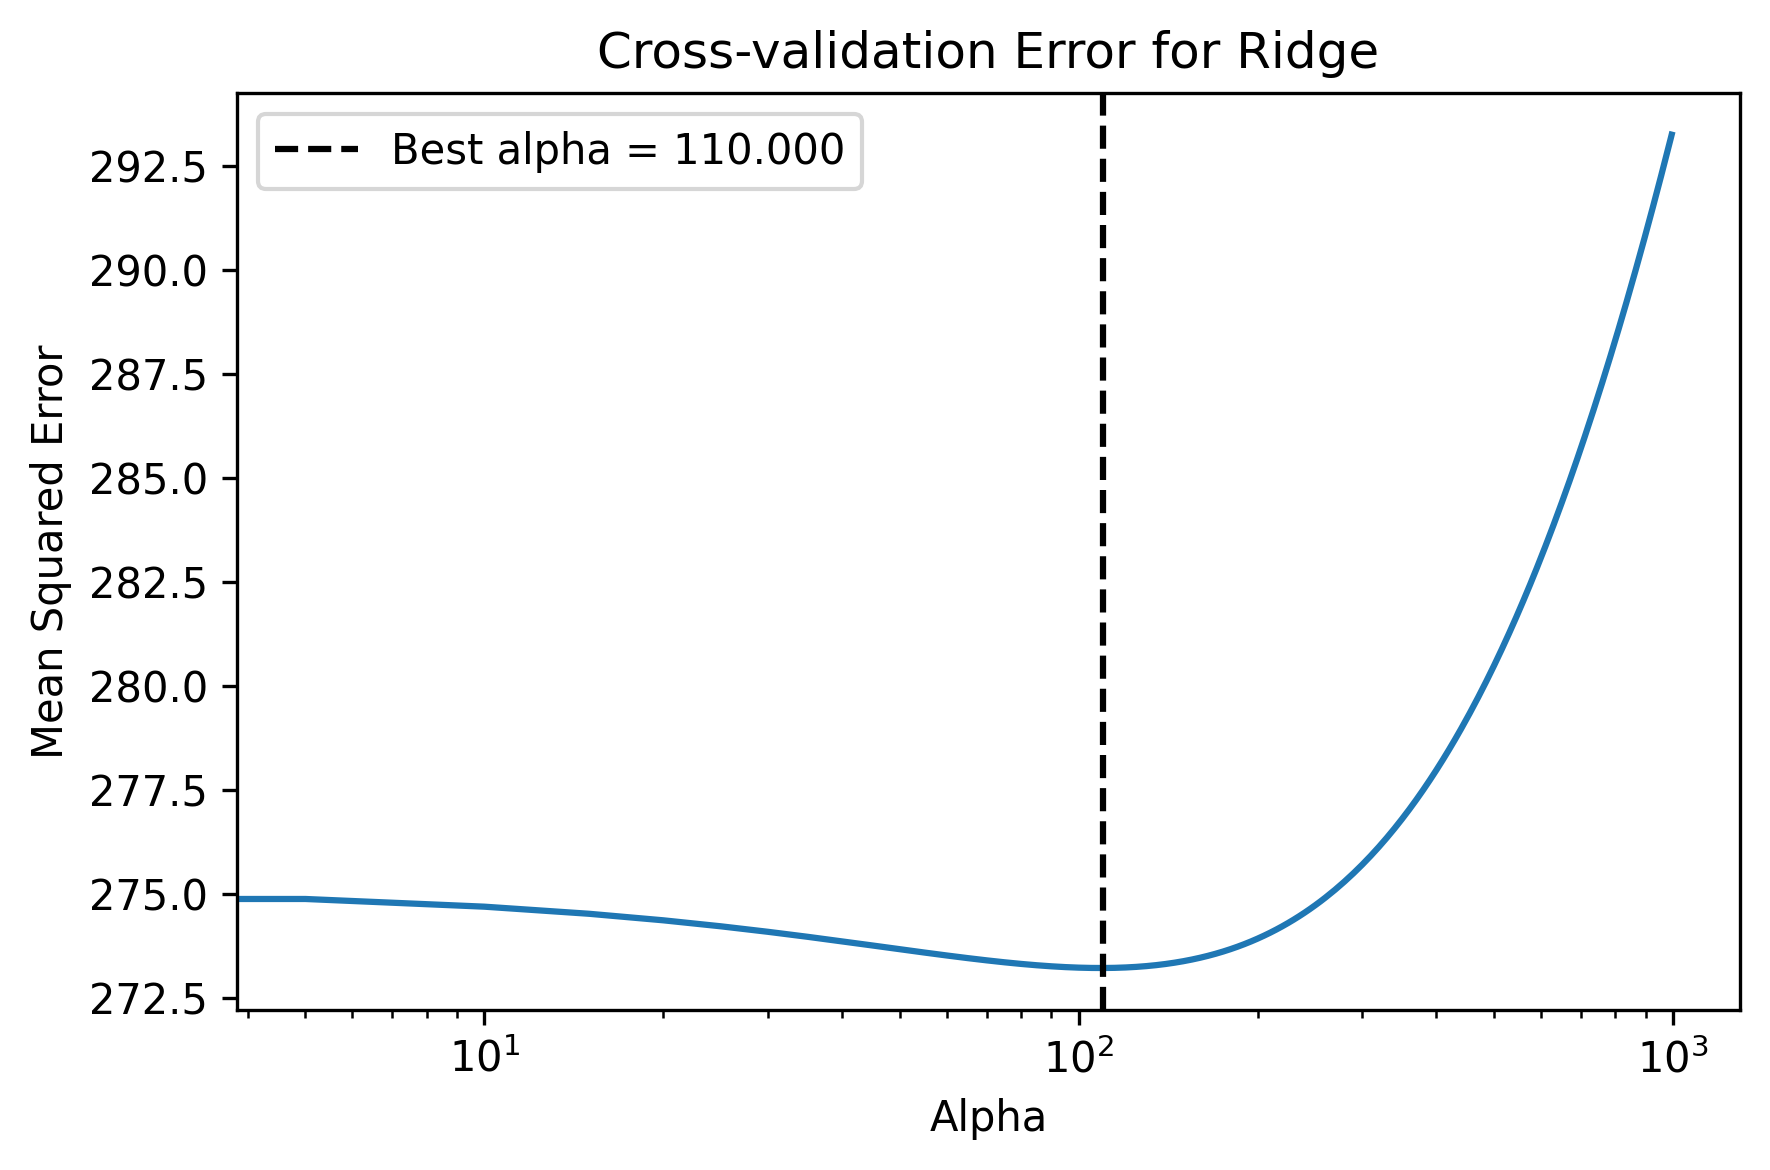

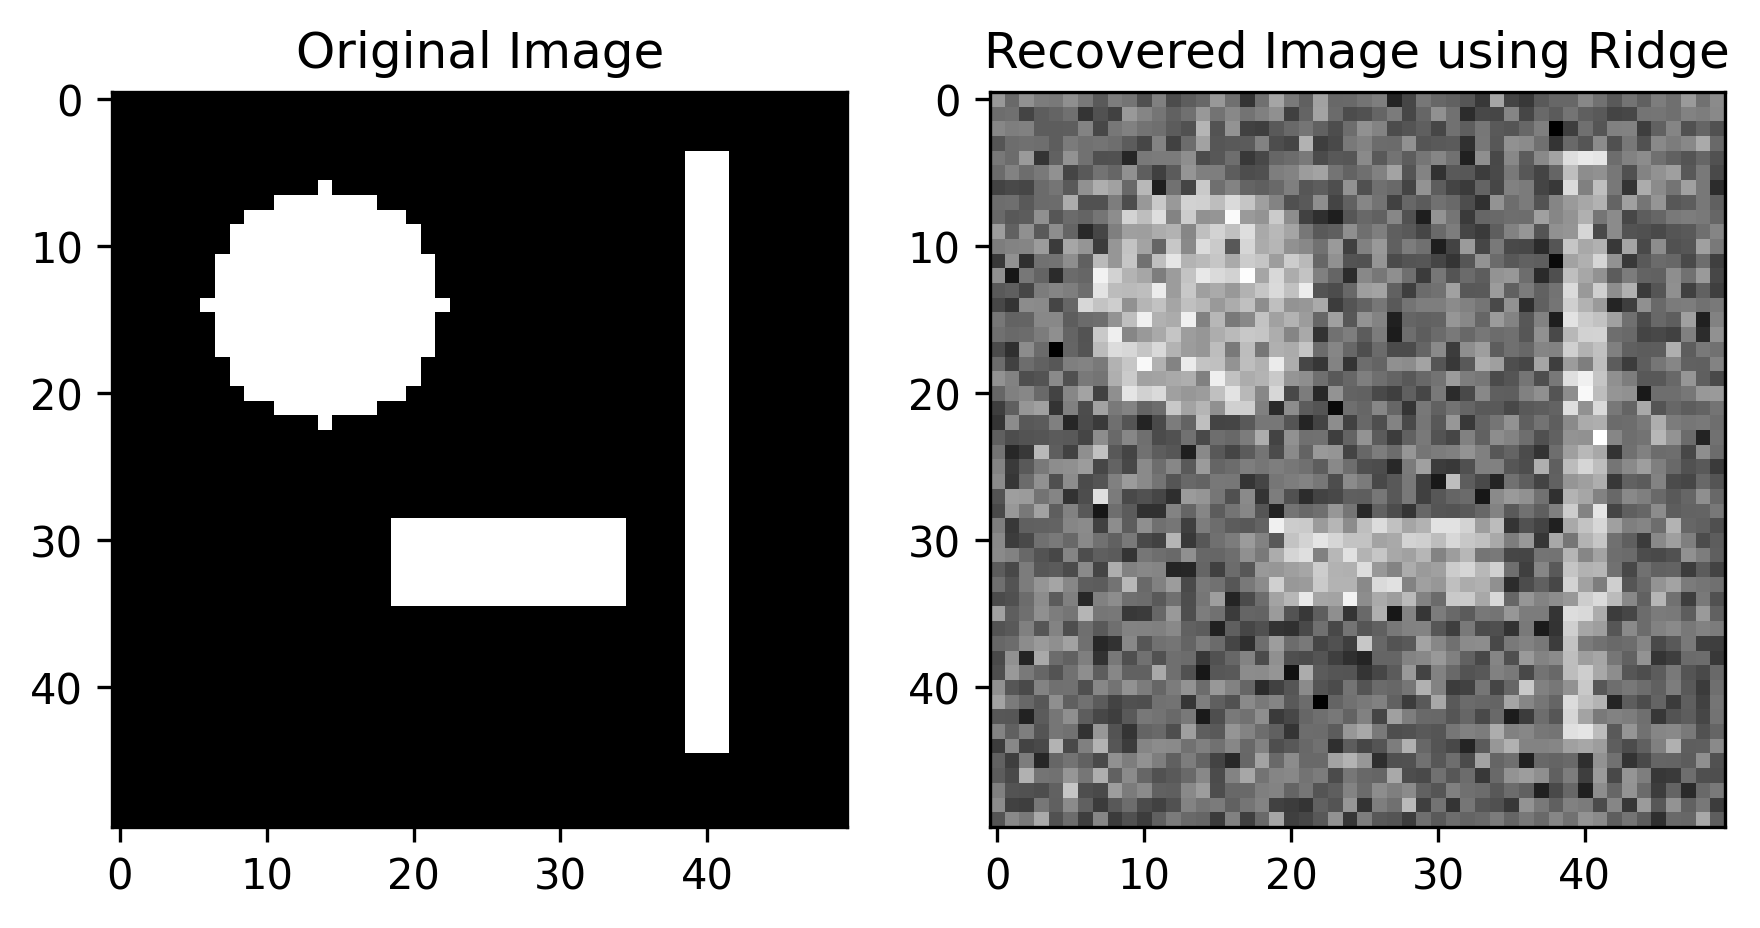

In [14]:
#|echo: false

plot_lasso_ridge(ridge_alphas, ridge_mses, best_ridge_alpha, title = 'Ridge', model = Ridge)

As evident from the recovered image plots above, lasso regression does a better job in portraying the true image when compared to ridge regression. The image recovered by lasso is clearer, less noisy, and has well distinguished boundaries for the shapes, making it easier to separate them from the background when compared to the recovered image by ridge regression. The background behind the shapes in the recovered image by lasso is more uniform than the image recovered by ridge regression as well. 